# Homework 5 - The Marvel Universe!

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## 1. Data

### Preprocessing

In [2]:
nodes = pd.read_csv('nodes.csv')

In [3]:
edges = pd.read_csv('edges.csv')

In [4]:
hero = pd.read_csv('hero-network.csv')

Take a look

In [5]:
nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [6]:
edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [7]:
hero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


We will not have to deal with NA values, now let's see in what format are the names/words written

In [8]:
nodes.head(10)

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
5,4-D MAN/MERCURIO,hero
6,8-BALL/,hero
7,A '00,comic
8,A '01,comic
9,A 100,comic


In [9]:
nodes.nunique()

node    19090
type        2
dtype: int64

In [10]:
edges.head(10)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
5,3-D MAN/CHARLES CHAN,H2 252
6,3-D MAN/CHARLES CHAN,M/PRM 35
7,3-D MAN/CHARLES CHAN,M/PRM 36
8,3-D MAN/CHARLES CHAN,M/PRM 37
9,3-D MAN/CHARLES CHAN,WI? 9


In [11]:
edges.nunique()

hero      6439
comic    12651
dtype: int64

In [12]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [13]:
hero.nunique()

hero1    6211
hero2    6173
dtype: int64

##### Problems:
 - Some heroes' names in 'hero-network.csv' have extra spaces at the end of their names compared to their names in 'edges.csv'
 - Some heroes' names in 'hero-network.csv' have an extra '/' at the end of their names compared to their names in 'edges.csv'
 - The hero name 'SPIDER-MAN/PETER PARKER' in 'edges.csv' has been changed to 'SPIDER-MAN/PETER PAR' in 'hero-network.csv' due to a string length limit in 'hero-network.csv'
 - Some entries in the 'hero-network.csv' have the same hero in both columns. In the graph, these entries form a self-loop. Because a self-loop makes no sense in this network, you can safely remove those from the dataset.

First of all, we remove the extra characters from the neroes' names.

In [14]:
hero["hero1"] = hero["hero1"].str.rstrip('/ ')
hero["hero2"] = hero["hero2"].str.rstrip('/ ')

In [15]:
hero.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [16]:
hero.nunique()

hero1    6206
hero2    6169
dtype: int64

We have less unique values after the rstrip, so there were actually some names that were the same but with extra characters.

Now let's change Spiderman's name in the hero dataframe to the complete 'SPIDER-MAN/PETER PARKER'.

In [17]:
hero[hero["hero1"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'
hero[hero["hero2"]=='SPIDER-MAN/PETER PAR']='SPIDER-MAN/PETER PARKER'

In [18]:
print(hero[hero["hero1"]=='SPIDER-MAN/PETER PAR'].shape)
print(hero[hero["hero2"]=='SPIDER-MAN/PETER PAR'].shape)

(0, 2)
(0, 2)


Done! No more short name for Spiderman.

The last problem we have is that some heroes appears to have had a self-collaboration which makes no sense, so we will delete the rows with the same hero in both columns.

In [19]:
hero = hero[hero["hero1"]!=hero["hero2"]]

### Graphs setup

**First graph**: Will be constructed using the data stored in the 'hero-network.csv' file, in which an edge between two heroes can be found if they have appeared in the same comic together. The number of edges between two heroes represents the number of times they have collaborated in different comics. The graph should be considered weighted and undirected. It is up to you to decide which metric to use to calculate the weights, but we anticipate that the cost will be lower for heroes with more collaborations. Please specify which metric you used to select the weights in the report.

First of all, we need to define a metric to calculate the weights so that the heroes with more collaborations has a lower 'cost'. In order to match the number of collaborations with an appropriate weight, we can use the inverse of the normalized number of collaborations for each hero. Just applying (max - X) / (max - min) to each value, we will obtain a 'cost' scaled between 0 and 1, meaning that if a collaboration has a weight close to 0 it is much more important than a collaboration with a weight close to 1.

We create a column with the number of collaboration for each pair of heroes.

In [20]:
hero['number of coll'] = hero.groupby(['hero1', 'hero2'])['hero1'].transform('count')

In [21]:
hero

,hero1,hero2,number of coll
0,"LITTLE, ABNER",PRINCESS ZANDA,5
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4
3,"LITTLE, ABNER",PRINCESS ZANDA,5
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,15
574463,CALLISTO,ROGUE,10
574464,CALLISTO,CALIBAN,5
574465,CALIBAN,ROGUE,6


We will use it only to compute the normalization, then we will delete it.

In [22]:
MAX = hero['number of coll'].max()

In [23]:
MIN = hero['number of coll'].min()

In [24]:
print(MAX)
print(MIN)

1267
1


In [25]:
hero['weight'] = (MAX - hero['number of coll'])/(MAX - MIN)

In [26]:
hero.head(15)

,hero1,hero2,number of coll,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,5,0.99684
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.99763
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.99763
3,"LITTLE, ABNER",PRINCESS ZANDA,5,0.99684
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,4,0.99763
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,4,0.99763
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC",2,0.99921
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA",1,1.00000
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK,1,1.00000
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.,1,1.00000


In [27]:
hero = hero.drop('number of coll', axis=1)

In [28]:
hero

,hero1,hero2,weight
0,"LITTLE, ABNER",PRINCESS ZANDA,0.996840
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.997630
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA,0.997630
3,"LITTLE, ABNER",PRINCESS ZANDA,0.996840
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL,0.997630
...,...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO,0.988942
574463,CALLISTO,ROGUE,0.992891
574464,CALLISTO,CALIBAN,0.996840
574465,CALIBAN,ROGUE,0.996051


Now we will use the NetworkX package and functions to create our graph.

In [29]:
graph1 = nx.from_pandas_edgelist(hero, 'hero1', 'hero2', edge_attr='weight')

In [ ]:
nx.draw(graph1)

**Second graph**: The data in 'nodes.csv' and 'edges.csv' will be used to construct the second graph. The type of node (hero/comic) can be found in 'nodes.csv', and an edge between a hero node and a comic node can be found in 'edges.csv' when the hero has appeared in that specific comic. This graph is assumed to be undirected and unweighted.

In [31]:
graph2 = nx.from_pandas_edgelist(edges, 'hero', 'comic')

In [32]:
graph2.add_nodes_from(nodes['node'], type=nodes['type'])

In [ ]:
nx.draw(graph2)

## 2. Backend Implementation

### Functionality 5 - Extracting Communities

First of all we want to reduce the dimensionality of our graphs. To do that we create a list of the most common heroes containing the name of the heroes appearing in the biggest number of comics.

In [33]:
def top_N(df, N):return df.groupby('hero').count().sort_values(['comic'], ascending = False).iloc[:N]

In [34]:
topHeroes = top_N(edges, 50)

In [35]:
topHeroes

,comic
hero,
SPIDER-MAN/PETER PARKER,1577
CAPTAIN AMERICA,1334
IRON MAN/TONY STARK,1150
THING/BENJAMIN J. GR,963
THOR/DR. DONALD BLAK,956
HUMAN TORCH/JOHNNY S,886
MR. FANTASTIC/REED R,854
HULK/DR. ROBERT BRUC,835
WOLVERINE/LOGAN,819


Now that we have a list of heroes, we use it to create a subgraph from the biggest graph. In this case we will use the graph1 which is the one created from the hero-network dataset.

In [36]:
subgraph1 = graph1.subgraph(topHeroes.index.tolist())

In [37]:
nx.info(subgraph1)

C:\Users\abell\AppData\Local\Temp\ipykernel_10468\2467672104.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(subgraph1)


'Graph with 48 nodes and 1099 edges'

In [38]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [39]:
def girvan_newman(graph):
    # find number of connected components
    cc = nx.connected_components(graph)
    cc_count = nx.number_connected_components(graph)
    removed=0

    while(cc_count == 1):
        removed+=1
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        cc = nx.connected_components(graph)
        cc_count = nx.number_connected_components(graph)

    return cc, removed

This is the complete funcion, taking in input two heroes and a graph, and giving back the communities, the number of nodes that have been removed, and whether the two heroes are in the same communities or not.

In [40]:
def extract_communities(graph, hero_1, hero_2):
    subgraph1 = graph.copy()
    sg, removed = girvan_newman(subgraph1)
    communities = []
    for c in sg:
        communities.append(list(c))
    same_community = False
    for i in communities:
        if hero_1 in i and hero_2 in i:
            same_community = True
            break

    return communities, removed, same_community

First trial of the functionality picking at random two heroes from the list of the most common ones.

In [41]:
hero1 = 'SCARLET WITCH/WANDA'
hero2 = 'HERCULES [GREEK GOD]'
communities, removed, same_community = extract_communities(subgraph1, hero1, hero2)

In [42]:
removed

41

In [43]:
communities

[['WONDER MAN/SIMON WIL',
  'STORM/ORORO MUNROE S',
  'INVISIBLE WOMAN/SUE',
  "BLACK PANTHER/T'CHAL",
  'HULK/DR. ROBERT BRUC',
  'ROBERTSON, JOE',
  'SHADOWCAT/KATHERINE',
  'FURY, COL. NICHOLAS',
  'BLACK WIDOW/NATASHA',
  'NIGHTCRAWLER/KURT WA',
  'MR. FANTASTIC/REED R',
  'CAPTAIN AMERICA',
  'MARVEL GIRL/JEAN GRE',
  'WATSON-PARKER, MARY',
  'THING/BENJAMIN J. GR',
  'ANT-MAN/DR. HENRY J.',
  'HERCULES [GREEK GOD]',
  'JAMESON, J. JONAH',
  'DR. STRANGE/STEPHEN',
  'HUMAN TORCH/JOHNNY S',
  'PROFESSOR X/CHARLES',
  'DAREDEVIL/MATT MURDO',
  'ANGEL/WARREN KENNETH',
  'PARKER, MAY',
  'RICHARDS, FRANKLIN B',
  'DR. DOOM/VICTOR VON',
  'QUICKSILVER/PIETRO M',
  'ODIN [ASGARDIAN]',
  'SCARLET WITCH/WANDA',
  'NELSON, FRANKLIN FOG',
  'THOR/DR. DONALD BLAK',
  'SHE-HULK/JENNIFER WA',
  'SUB-MARINER/NAMOR MA',
  'WOLVERINE/LOGAN',
  'PUNISHER II/FRANK CA',
  'HAWK',
  'CYCLOPS/SCOTT SUMMER',
  'VISION',
  'COLOSSUS II/PETER RA',
  'JONES, RICHARD MILHO',
  'JARVIS, EDWIN',
  'CAPTAIN B

In [44]:
same_community

True

## 3. Frontend Implementation

### Visualization 5 - Visualize the communities

 - Print the number of links that should be removed to have the communities

In [45]:
print(removed)

41


 - A table depicting the communities and the heroes that belong to each community

In [46]:
pip install tabulate

In [47]:
from tabulate import tabulate

In [48]:
comm1=communities[0]
comm2=communities[1]

print(len(comm1))
print(len(comm2))

47
1


In [49]:
for i in range(len(comm1)-len(comm2)):
    comm2.append('NA')

In [50]:
print(len(comm1))
print(len(comm2))

47
47


In [51]:
d = {'comm1': comm1, 'comm2': comm2}
headers=['comm1', 'comm2']
dfcomm = pd.DataFrame(data=d)

In [52]:
print(tabulate(dfcomm, headers=headers, floatfmt=".4f"))

    comm1                 comm2
--  --------------------  --------------------
 0  WONDER MAN/SIMON WIL  CANNONBALL II/SAM GU
 1  STORM/ORORO MUNROE S  NA
 2  INVISIBLE WOMAN/SUE   NA
 3  BLACK PANTHER/T'CHAL  NA
 4  HULK/DR. ROBERT BRUC  NA
 5  ROBERTSON, JOE        NA
 6  SHADOWCAT/KATHERINE   NA
 7  FURY, COL. NICHOLAS   NA
 8  BLACK WIDOW/NATASHA   NA
 9  NIGHTCRAWLER/KURT WA  NA
10  MR. FANTASTIC/REED R  NA
11  CAPTAIN AMERICA       NA
12  MARVEL GIRL/JEAN GRE  NA
13  WATSON-PARKER, MARY   NA
14  THING/BENJAMIN J. GR  NA
15  ANT-MAN/DR. HENRY J.  NA
16  HERCULES [GREEK GOD]  NA
17  JAMESON, J. JONAH     NA
18  DR. STRANGE/STEPHEN   NA
19  HUMAN TORCH/JOHNNY S  NA
20  PROFESSOR X/CHARLES   NA
21  DAREDEVIL/MATT MURDO  NA
22  ANGEL/WARREN KENNETH  NA
23  PARKER, MAY           NA
24  RICHARDS, FRANKLIN B  NA
25  DR. DOOM/VICTOR VON   NA
26  QUICKSILVER/PIETRO M  NA
27  ODIN [ASGARDIAN]      NA
28  SCARLET WITCH/WANDA   NA
29  NELSON, FRANKLIN FOG  NA
30  THOR/DR. DONALD BLAK  NA
31  

 - Plot the original graph

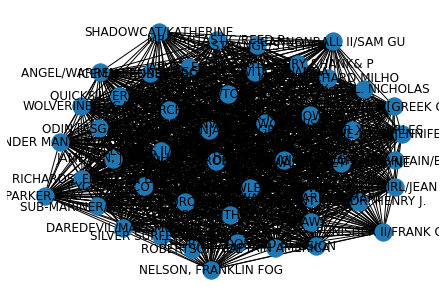

In [53]:
nx.draw(subgraph1, with_labels=True)

 - Plot the graph showing the communities in the network

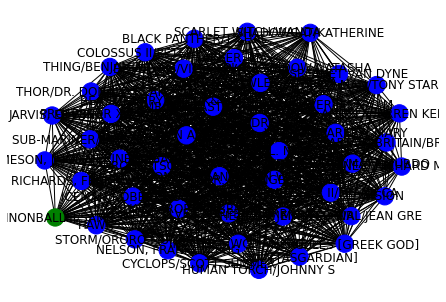

In [54]:
color_map = []
for node in subgraph1:
    if node in communities[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(subgraph1, node_color=color_map, with_labels=True)
plt.show()

 - Plot the final graph and identify the community/communities of Hero_1 and Hero_2

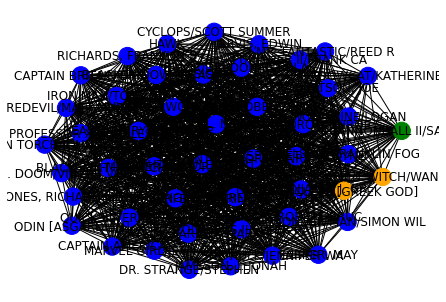

In [56]:
color_map = []
for node in subgraph1:
    if node in communities[0]:
        if node==hero1 or node==hero2:
            color_map.append('orange')
        else:
            color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(subgraph1, node_color=color_map, with_labels=True)
plt.show()